# Training Script 
This notebook uses the different algorithms for training

In [ ]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import csv
import warnings
import glob

warnings.filterwarnings("ignore")

class ParcelEvaluator:
    """
    A class to evaluate and analyze parcel predictions against original parcels.
    This class compares original parcels with predicted parcels, calculates metrics,
    and identifies overpredictions and low-performing predictions.
    """

    def __init__(self, original_dir, predicted_dir):
        """
        Initialize the ParcelEvaluator with directories containing original and predicted parcel data.
        """
        self.original_dir = Path(original_dir)
        self.predicted_dir = Path(predicted_dir)
        self.output_dir = self.create_folder()

    def create_folder(self):
        """Create output folder for evaluation results."""
        output_dir = self.predicted_dir.parent / 'evaluation'
        output_dir.mkdir(exist_ok=True)
        return output_dir
    
    def load_gdf(self, path):
        """Load GeoDataFrame from file."""
        return gpd.read_file(path)

    def explode_multipolygons(self, gdf):
        """
        Explode MultiPolygons in a GeoDataFrame into individual Polygons.
        This is necessary to ensure each geometry is a single Polygon for accurate analysis.
        """
        if any(gdf.geometry.type == 'MultiPolygon'):
            return gdf.explode(index_parts=False).reset_index(drop=True)
        return gdf

    def calculate_overlap(self, original_polygon, predicted_polygons):
        """
        Calculate the overlap between an original polygon and predicted polygons.
        This function computes the true positive (correctly predicted area) and
        false negative (missed area) for a single original parcel.
        true_positive: Area of intersection between original and predicted polygons
        false_negative: Area of original polygon not covered by predicted polygons
        parameters: 
        - original_polygon:  A single polygon representing the ground truth or original parcel.
        - predicted_polygons: predicted parcel polygons that intersect with the original polygon
        """
        if predicted_polygons.empty:
            return 0, original_polygon.area
        
        # Calculate the intersection between original and predicted polygons
        intersection = gpd.overlay(gpd.GeoDataFrame(geometry=[original_polygon]), 
                                   predicted_polygons, how='intersection')
        true_positive = intersection.area.sum()
        false_negative = original_polygon.area - true_positive
        return true_positive, false_negative

    def evaluate_parcels(self):
        """
        Evaluate parcels by calculating the Adjusted IoU for each original parcel.
        This function iterates through all original parcels, calculates their overlap
        with predicted parcels, and computes an Adjusted IoU (Intersection over Union) score.
        """
        results = []
        for idx, original_row in self.original_gdf.iterrows():
            original_polygon = original_row.geometry
            intersecting_predictions = self.predicted_gdf[self.predicted_gdf.intersects(original_polygon)]
            true_positive, false_negative = self.calculate_overlap(original_polygon, intersecting_predictions)
            adjusted_iou = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
            results.append({
                'Parcel ID': idx,
                'Adjusted IoU': adjusted_iou
            })
        results_df = pd.DataFrame(results)
        results_df.set_index('Parcel ID', inplace=True)
        return results_df

    def identify_overpredictions(self):
        """
        Identify overpredicted areas by comparing original and predicted parcels.
        This function finds areas that are predicted as parcels but don't exist in the original data.
        It returns only overpredicted areas larger than 5000 m².
        """
        original_combined = self.original_gdf.unary_union
        predicted_combined = self.predicted_gdf.unary_union
        overpredicted_area = predicted_combined.difference(original_combined)
        overpredicted_gdf = gpd.GeoDataFrame(geometry=[overpredicted_area], crs=self.original_gdf.crs)
        overpredicted_gdf = self.explode_multipolygons(overpredicted_gdf)
        overpredicted_gdf = overpredicted_gdf[overpredicted_gdf.geometry.area > 5000]
        return overpredicted_gdf

    def identify_underpredictions(self):
        """
        Identify underpredicted areas by comparing original and predicted parcels.
        This function finds areas that exist in the original data but are not predicted as parcels.
        It returns only underpredicted areas larger than 5000 m².
        """
        original_combined = self.original_gdf.unary_union
        predicted_combined = self.predicted_gdf.unary_union
        underpredicted_area = original_combined.difference(predicted_combined)
        underpredicted_gdf = gpd.GeoDataFrame(geometry=[underpredicted_area], crs=self.original_gdf.crs)
        underpredicted_gdf = self.explode_multipolygons(underpredicted_gdf)
        underpredicted_gdf = underpredicted_gdf[underpredicted_gdf.geometry.area > 5000]
        return underpredicted_gdf

    def analyze_parcels(self):
        """
        Analyze parcels for all matching files in the directories.
        This function processes each pair of original and predicted parcel files,
        calculates various metrics, and saves the results.
        """
        statistics = []
        predicted_files = glob.glob(str(self.predicted_dir / 'ZH_ZH_parcel_*.gpkg'))

        for predicted_file in predicted_files:
            filename = Path(predicted_file).name
            original_file = self.original_dir / filename

            if original_file.exists():
                self.original_gdf = self.load_gdf(original_file)
                self.predicted_gdf = self.load_gdf(predicted_file)

                if self.original_gdf.crs is None:
                    self.original_gdf.set_crs(epsg=32632, inplace=True)

                if self.original_gdf.crs != self.predicted_gdf.crs:
                    self.predicted_gdf = self.predicted_gdf.to_crs(self.original_gdf.crs)

                results_df = self.evaluate_parcels()
                self.original_gdf['Adjusted IoU'] = results_df['Adjusted IoU']
                
                analysis_gdf = self.explode_multipolygons(self.original_gdf)
                analysis_gdf = analysis_gdf[analysis_gdf.geometry.area > 5000]
                
                overpredicted_gdf = self.identify_overpredictions()
                underpredicted_gdf = self.identify_underpredictions()
                
                # Handle potential empty overpredicted_gdf and underpredicted_gdf
                if not overpredicted_gdf.empty:
                    analysis_gdf['Overpredicted'] = analysis_gdf.geometry.intersects(overpredicted_gdf.unary_union)
                else:
                    analysis_gdf['Overpredicted'] = False

                if not underpredicted_gdf.empty:
                    analysis_gdf['Underpredicted'] = analysis_gdf.geometry.intersects(underpredicted_gdf.unary_union)
                else:
                    analysis_gdf['Underpredicted'] = False

                analysis_gdf['Low IoU'] = analysis_gdf['Adjusted IoU'] <= 0.7
                
                true_positives = []
                false_negatives = []
                for idx, original_row in analysis_gdf.iterrows():
                    original_polygon = original_row.geometry
                    intersecting_predictions = self.predicted_gdf[self.predicted_gdf.intersects(original_polygon)]
                    true_positive, false_negative = self.calculate_overlap(original_polygon, intersecting_predictions)
                    true_positives.append(true_positive)
                    false_negatives.append(false_negative)
                
                analysis_gdf['True Positive (m²)'] = true_positives
                analysis_gdf['False Negative (m²)'] = false_negatives
                
                low_iou_gdf = analysis_gdf[analysis_gdf['Low IoU']]
                
                if not overpredicted_gdf.empty:
                    overpredicted_gdf['Adjusted IoU'] = None
                    overpredicted_gdf['Overpredicted'] = True
                    overpredicted_gdf['Underpredicted'] = False
                    overpredicted_gdf['Low IoU'] = False
                    overpredicted_gdf['True Positive (m²)'] = None
                    overpredicted_gdf['False Negative (m²)'] = None
                    combined_gdf = pd.concat([analysis_gdf, overpredicted_gdf], ignore_index=True)
                else:
                    combined_gdf = analysis_gdf

                if not underpredicted_gdf.empty:
                    underpredicted_gdf['Adjusted IoU'] = None
                    underpredicted_gdf['Overpredicted'] = False
                    underpredicted_gdf['Underpredicted'] = True
                    underpredicted_gdf['Low IoU'] = False
                    underpredicted_gdf['True Positive (m²)'] = None
                    underpredicted_gdf['False Negative (m²)'] = None
                    combined_gdf = pd.concat([combined_gdf, underpredicted_gdf], ignore_index=True)
                
                output_filename = Path(filename).stem
                combined_gdf.to_file(f"{self.output_dir/output_filename}_analysis.gpkg", driver="GPKG")
                if not overpredicted_gdf.empty:
                    overpredicted_gdf.to_file(f"{self.output_dir/output_filename}_overprediction.gpkg", driver="GPKG")
                if not underpredicted_gdf.empty:
                    underpredicted_gdf.to_file(f"{self.output_dir/output_filename}_underprediction.gpkg", driver="GPKG")
                low_iou_gdf.to_file(f"{self.output_dir/output_filename}_low_iou.gpkg", driver="GPKG")

                total_area = analysis_gdf.geometry.area.sum()
                overpredicted_area = overpredicted_gdf.geometry.area.sum() if not overpredicted_gdf.empty else 0
                underpredicted_area = underpredicted_gdf.geometry.area.sum() if not underpredicted_gdf.empty else 0
                low_iou_area = low_iou_gdf.geometry.area.sum()

                total_error = (overpredicted_area + underpredicted_area + low_iou_area) / total_area if total_area > 0 else 0
                overprediction_error = overpredicted_area / total_area if total_area > 0 else 0
                underprediction_error = underpredicted_area / total_area if total_area > 0 else 0
                low_iou_error = low_iou_area / total_area if total_area > 0 else 0

                parcel_statistics = {
                    'Parcel Name': output_filename,
                    'Total Area (m²)': total_area,
                    'Overpredicted Area (m²)': overpredicted_area,
                    'Underpredicted Area (m²)': underpredicted_area,
                    'Low IoU Area (m²)': low_iou_area,
                    'Total Error': total_error,
                    'Overprediction Error': overprediction_error,
                    'Underprediction Error': underprediction_error,
                    'Low IoU Error': low_iou_error,
                    'Correct Prediction (%)': (1 - total_error) * 100,
                    'Overprediction (%)': overprediction_error * 100,
                    'Underprediction (%)': underprediction_error * 100,
                    'Low IoU (%)': low_iou_error * 100
                }

                statistics.append(parcel_statistics)

        # Save all statistics to a single CSV file
        if statistics:
            with open(f"{self.output_dir}/statistics.csv", 'w', newline='') as csvfile:
                fieldnames = statistics[0].keys()
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for stat in statistics:
                    writer.writerow(stat)
        else:
            print("No statistics generated. Check if there are matching files in the directories.")

# Usage example
evaluator = ParcelEvaluator("/workspaces/Satelite/data/parcels/",
                            "/workspaces/Satelite/data/experiment/predictions/")
evaluator.analyze_parcels()

In [7]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)


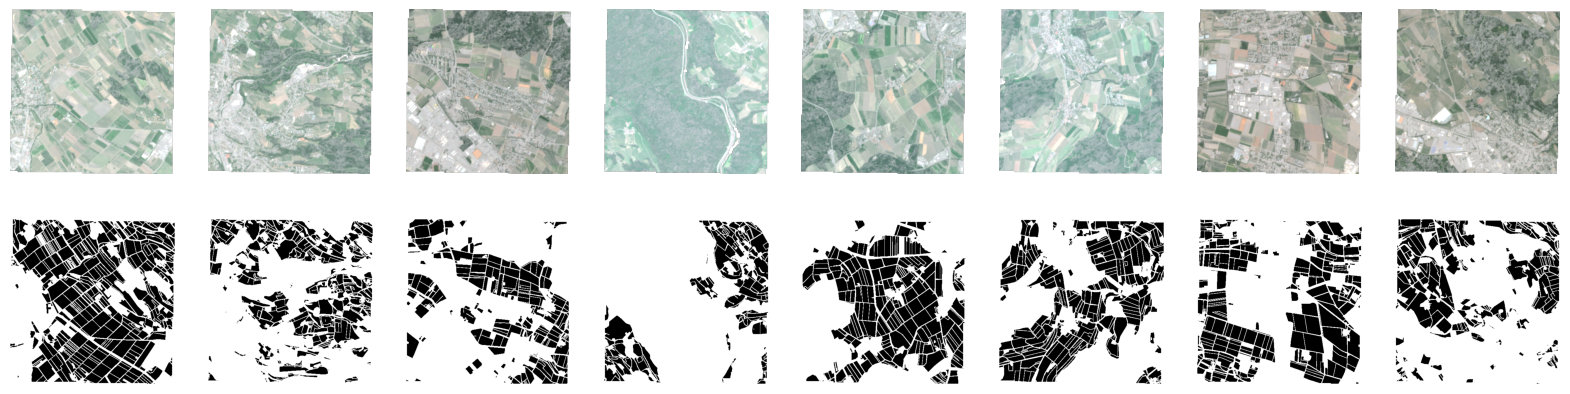

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
        ax[1, i].axis('off')
    plt.show()
    
path = "/workspaces/Satelite/data/dataset_upscaled_False/train"
train_data = tf.data.Dataset.load(path)

# Load the images and masks
images = []
masks = []

for image, mask in train_data.take(count=8):
    print(image.shape, mask.shape)
    images.append(image.numpy())
    masks.append(mask.numpy())

# Plot the images and masks
plot_images(images, masks, num_images=8)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from helpers.load import LoadandAugment
from helpers import model

input_shape = (256,256,4)
UNET = model.DeepUnet(input_shape, NUM_CLASSES=1, dropout_rate=0, batch_norm=True)

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders with correct target shape
train_data = LoadandAugment(train_path, "train", 16, True)
val_data = LoadandAugment(val_path, "val", 16, True)

# Initialize UNET model with correct input shape
UNET.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
UNET.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=100, 
    callbacks=[checkpoint_callback]
)

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import tensorflow as tf
import rasterio
from rasterio.transform import from_origin
from helpers.load import LoadandAugment



# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
test_path = os.path.join(path, "test")

#  Load the test file mapping
with open('/workspaces/Satelite/data/dataset_upscaled_False/test_file_mapping.json', 'r') as f:
    test_file_mapping = json.load(f)

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load model and weights
UNET.load_weights('best_model.h5')
test_data_loader = LoadandAugment(test_path, "test", 5, True)

# Get the test dataset
test_dataset = test_data_loader.dataset

# Predict on the test data
for images, masks in test_dataset.take(1):
    predictions = UNET.predict(images)
    predictions = (predictions > 0.5).astype(np.float32) 

# Check predictions
print("Min prediction value:", predictions.min())
print("Max prediction value:", predictions.max())

# Save predictions as .tif files
for idx, prediction in enumerate(predictions):
    # Get the original mask path
    original_mask_path = test_file_mapping[idx]["mask"]
    
    # Read the original mask to get the metadata
    with rasterio.open(original_mask_path) as src:
        metadata = src.meta.copy()
        metadata.update({
            "count": 1,
            "dtype": 'float32'
        })
        
        # Save the predicted mask with the same metadata
        predicted_mask_path = original_mask_path.replace('mask', 'predicted_mask')
        with rasterio.open(predicted_mask_path, 'w', **metadata) as dst:
            dst.write(prediction.squeeze(), 1)

# Plot the predictions
plot_predictions(images.numpy(), masks.numpy(), predictions)


2024-06-20 18:33:07.063557: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 18:33:07.200483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'UNET' is not defined

In [4]:
import os
import numpy as np
import geopandas as gpd
from skimage import io
from skimage.measure import find_contours
from shapely.geometry import Polygon
from rdp import rdp
import matplotlib.pyplot as plt

# Define the paths
predicted_mask_folder = '/workspaces/Satelite/data/predicted_mask'
original_mask_path = "/workspaces/Satelite/data/mask"

# Get the list of predicted and original mask filenames
predicted_mask_files = [file for file in os.listdir(predicted_mask_folder) if file.endswith('.tif')]
original_mask_files = [file for file in os.listdir(original_mask_path) if file.endswith('.tif')]

# Find the common filenames
common_files = set(predicted_mask_files).intersection(set(original_mask_files))

# Sort the common filenames
common_files = sorted(common_files)

# Read the masks in sorted order
predicted_masks = [io.imread(os.path.join(predicted_mask_folder, file)) for file in common_files]
original_masks = [io.imread(os.path.join(original_mask_path, file)) for file in common_files]

def extract_polygons(mask):
    # Rotate the mask if needed (assuming 90 degrees clockwise rotation)
    mask = np.rot90(mask, k=-1)
    
    # Find contours in the mask
    contours = find_contours(mask, level=0.5)
    
    # Create an empty list to store the polygons
    polygons = []
    
    # Iterate over each contour
    for contour in contours:
        # Simplify the contour using Ramer-Douglas-Peucker algorithm
        simplified_contour = rdp(contour, epsilon=1.0)
        
        # Check if the simplified contour has at least 4 coordinates
        if len(simplified_contour) >= 4:
            # Create a Polygon object from the simplified contour
            polygon = Polygon(simplified_contour)
            
            # Append the polygon to the list
            polygons.append(polygon)
    
    return polygons

def create_geodataframe(polygons, crs='EPSG:32632'):
    # Create a GeoDataFrame from the list of polygons
    gdf = gpd.GeoDataFrame(geometry=polygons)
    
    # Set the CRS of the GeoDataFrame
    gdf.set_crs(crs, inplace=True)
    
    return gdf

def save_geodataframe(gdf, filename):
    # Save the GeoDataFrame to a file (e.g., GeoPackage)
    gdf.to_file(filename, driver="GPKG")

# Extract polygons for original and predicted masks
original_polygons = [extract_polygons(mask) for mask in original_masks]
predicted_polygons = [extract_polygons(mask) for mask in predicted_masks]

# Create GeoDataFrames for original and predicted masks
original_gdfs = [create_geodataframe(polygons) for polygons in original_polygons]
predicted_gdfs = [create_geodataframe(polygons) for polygons in predicted_polygons]

# Save the GeoDataFrames to files
for i, filename in enumerate(common_files):
    original_filename = f"original_{filename.split('.')[0]}.gpkg"
    predicted_filename = f"predicted_{filename.split('.')[0]}.gpkg"
    
    save_geodataframe(original_gdfs[i], original_filename)
    save_geodataframe(predicted_gdfs[i], predicted_filename)

print("GeoDataFrames saved successfully.")


GeoDataFrames saved successfully.


In [ ]:

# Rotate the mask if needed (assuming 90 degrees clockwise rotation)
mask = np.rot90(mask, k=-1)

# Find contours in the mask
contours = find_contours(mask, level=0.5)

# Create an empty list to store the polygons
polygons = []

# Iterate over each contour
for contour in contours:
    # Simplify the contour using Ramer-Douglas-Peucker algorithm
    simplified_contour = rdp(contour, epsilon=1.0)
    
    # Check if the simplified contour has at least 4 coordinates
    if len(simplified_contour) >= 4:
        # Create a Polygon object from the simplified contour
        polygon = Polygon(simplified_contour)
        
        # Append the polygon to the list
        polygons.append(polygon)

# Create a GeoDataFrame from the list of polygons
gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the CRS of the GeoDataFrame (replace 'EPSG:4326' with the appropriate CRS)
# EPSG:32632 - WGS 84 / UTM zone 32N

# Save the GeoDataFrame to a file (e.g., geodataframe gpkg)
gdf.to_file("polygons.gpkg", driver="GPKG")

In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import csv
import warnings
import glob

warnings.filterwarnings("ignore")

class ParcelEvaluator:
    """
    A class to evaluate and analyze parcel predictions against original parcels.
    This class compares original parcels with predicted parcels, calculates metrics,
    and identifies overpredictions and low-performing predictions.
    """

    def __init__(self, original_dir, predicted_dir):
        """
        Initialize the ParcelEvaluator with directories containing original and predicted parcel data.
        """
        self.original_dir = Path(original_dir)
        self.predicted_dir = Path(predicted_dir)
        self.output_dir = self.create_folder()

    def create_folder(self):
        """Create output folder for evaluation results."""
        output_dir = self.predicted_dir.parent / 'evaluation'
        output_dir.mkdir(exist_ok=True)
        return output_dir
    
    def load_gdf(self, path):
        """Load GeoDataFrame from file."""
        return gpd.read_file(path)

    def explode_multipolygons(self, gdf):
        """
        Explode MultiPolygons in a GeoDataFrame into individual Polygons.
        This is necessary to ensure each geometry is a single Polygon for accurate analysis.
        """
        if any(gdf.geometry.type == 'MultiPolygon'):
            return gdf.explode(index_parts=False).reset_index(drop=True)
        return gdf

    def calculate_overlap(self, original_polygon, predicted_polygons):
        """
        Calculate the overlap between an original polygon and predicted polygons.
        This function computes the true positive (correctly predicted area) and
        false negative (missed area) for a single original parcel.
        true_positive: Area of intersection between original and predicted polygons
        false_negative: Area of original polygon not covered by predicted polygons
        parameters: 
        - original_polygon:  A single polygon representing the ground truth or original parcel.
        - predicted_polygons: predicted parcel polygons that intersect with the original polygon
        """
        if predicted_polygons.empty:
            return 0, original_polygon.area
        
        # Calculate the intersection between original and predicted polygons
        intersection = gpd.overlay(gpd.GeoDataFrame(geometry=[original_polygon]), 
                                   predicted_polygons, how='intersection')
        true_positive = intersection.area.sum()
        false_negative = original_polygon.area - true_positive
        return true_positive, false_negative

    def evaluate_parcels(self):
        """
        Evaluate parcels by calculating the Adjusted IoU for each original parcel.
        This function iterates through all original parcels, calculates their overlap
        with predicted parcels, and computes an Adjusted IoU (Intersection over Union) score.
        """
        results = []
        for idx, original_row in self.original_gdf.iterrows():
            original_polygon = original_row.geometry
            intersecting_predictions = self.predicted_gdf[self.predicted_gdf.intersects(original_polygon)]
            true_positive, false_negative = self.calculate_overlap(original_polygon, intersecting_predictions)
            adjusted_iou = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
            results.append({
                'Parcel ID': idx,
                'Adjusted IoU': adjusted_iou
            })
        results_df = pd.DataFrame(results)
        results_df.set_index('Parcel ID', inplace=True)
        return results_df

    def identify_overpredictions(self):
        """
        Identify overpredicted areas by comparing original and predicted parcels.
        This function finds areas that are predicted as parcels but don't exist in the original data.
        It returns only overpredicted areas larger than 5000 m².
        """
        original_combined = self.original_gdf.unary_union
        predicted_combined = self.predicted_gdf.unary_union
        overpredicted_area = predicted_combined.difference(original_combined)
        overpredicted_gdf = gpd.GeoDataFrame(geometry=[overpredicted_area], crs=self.original_gdf.crs)
        overpredicted_gdf = self.explode_multipolygons(overpredicted_gdf)
        overpredicted_gdf = overpredicted_gdf[overpredicted_gdf.geometry.area > 5000]
        return overpredicted_gdf

    def identify_underpredictions(self):
        """
        Identify underpredicted areas by comparing original and predicted parcels.
        This function finds areas that exist in the original data but are not predicted as parcels.
        It returns only underpredicted areas larger than 5000 m².
        """
        original_combined = self.original_gdf.unary_union
        predicted_combined = self.predicted_gdf.unary_union
        underpredicted_area = original_combined.difference(predicted_combined)
        underpredicted_gdf = gpd.GeoDataFrame(geometry=[underpredicted_area], crs=self.original_gdf.crs)
        underpredicted_gdf = self.explode_multipolygons(underpredicted_gdf)
        underpredicted_gdf = underpredicted_gdf[underpredicted_gdf.geometry.area > 5000]
        return underpredicted_gdf

    def analyze_parcels(self):
        """
        Analyze parcels for all matching files in the directories.
        This function processes each pair of original and predicted parcel files,
        calculates various metrics, and saves the results.
        """
        statistics = []
        predicted_files = glob.glob(str(self.predicted_dir / 'ZH_ZH_parcel_*.gpkg'))

        for predicted_file in predicted_files:
            filename = Path(predicted_file).name
            original_file = self.original_dir / filename

            if original_file.exists():
                self.original_gdf = self.load_gdf(original_file)
                self.predicted_gdf = self.load_gdf(predicted_file)

                if self.original_gdf.crs is None:
                    self.original_gdf.set_crs(epsg=32632, inplace=True)

                if self.original_gdf.crs != self.predicted_gdf.crs:
                    self.predicted_gdf = self.predicted_gdf.to_crs(self.original_gdf.crs)

                results_df = self.evaluate_parcels()
                self.original_gdf['Adjusted IoU'] = results_df['Adjusted IoU']
                
                analysis_gdf = self.explode_multipolygons(self.original_gdf)
                analysis_gdf = analysis_gdf[analysis_gdf.geometry.area > 5000]
                
                overpredicted_gdf = self.identify_overpredictions()
                underpredicted_gdf = self.identify_underpredictions()
                
                # Handle potential empty overpredicted_gdf and underpredicted_gdf
                if not overpredicted_gdf.empty:
                    analysis_gdf['Overpredicted'] = analysis_gdf.geometry.intersects(overpredicted_gdf.unary_union)
                else:
                    analysis_gdf['Overpredicted'] = False

                if not underpredicted_gdf.empty:
                    analysis_gdf['Underpredicted'] = analysis_gdf.geometry.intersects(underpredicted_gdf.unary_union)
                else:
                    analysis_gdf['Underpredicted'] = False

                analysis_gdf['Low IoU'] = analysis_gdf['Adjusted IoU'] <= 0.7
                
                true_positives = []
                false_negatives = []
                for idx, original_row in analysis_gdf.iterrows():
                    original_polygon = original_row.geometry
                    intersecting_predictions = self.predicted_gdf[self.predicted_gdf.intersects(original_polygon)]
                    true_positive, false_negative = self.calculate_overlap(original_polygon, intersecting_predictions)
                    true_positives.append(true_positive)
                    false_negatives.append(false_negative)
                
                analysis_gdf['True Positive (m²)'] = true_positives
                analysis_gdf['False Negative (m²)'] = false_negatives
                
                low_iou_gdf = analysis_gdf[analysis_gdf['Low IoU']]
                
                if not overpredicted_gdf.empty:
                    overpredicted_gdf['Adjusted IoU'] = None
                    overpredicted_gdf['Overpredicted'] = True
                    overpredicted_gdf['Underpredicted'] = False
                    overpredicted_gdf['Low IoU'] = False
                    overpredicted_gdf['True Positive (m²)'] = None
                    overpredicted_gdf['False Negative (m²)'] = None
                    combined_gdf = pd.concat([analysis_gdf, overpredicted_gdf], ignore_index=True)
                else:
                    combined_gdf = analysis_gdf

                if not underpredicted_gdf.empty:
                    underpredicted_gdf['Adjusted IoU'] = None
                    underpredicted_gdf['Overpredicted'] = False
                    underpredicted_gdf['Underpredicted'] = True
                    underpredicted_gdf['Low IoU'] = False
                    underpredicted_gdf['True Positive (m²)'] = None
                    underpredicted_gdf['False Negative (m²)'] = None
                    combined_gdf = pd.concat([combined_gdf, underpredicted_gdf], ignore_index=True)
                
                output_filename = Path(filename).stem
                combined_gdf.to_file(f"{self.output_dir/output_filename}_analysis.gpkg", driver="GPKG")
                if not overpredicted_gdf.empty:
                    overpredicted_gdf.to_file(f"{self.output_dir/output_filename}_overprediction.gpkg", driver="GPKG")
                if not underpredicted_gdf.empty:
                    underpredicted_gdf.to_file(f"{self.output_dir/output_filename}_underprediction.gpkg", driver="GPKG")
                low_iou_gdf.to_file(f"{self.output_dir/output_filename}_low_iou.gpkg", driver="GPKG")

                total_area = analysis_gdf.geometry.area.sum()
                overpredicted_area = overpredicted_gdf.geometry.area.sum() if not overpredicted_gdf.empty else 0
                underpredicted_area = underpredicted_gdf.geometry.area.sum() if not underpredicted_gdf.empty else 0
                low_iou_area = low_iou_gdf.geometry.area.sum()

                total_error = (overpredicted_area + underpredicted_area + low_iou_area) / total_area if total_area > 0 else 0
                overprediction_error = overpredicted_area / total_area if total_area > 0 else 0
                underprediction_error = underpredicted_area / total_area if total_area > 0 else 0
                low_iou_error = low_iou_area / total_area if total_area > 0 else 0

                parcel_statistics = {
                    'Parcel Name': output_filename,
                    'Total Area (m²)': total_area,
                    'Overpredicted Area (m²)': overpredicted_area,
                    'Underpredicted Area (m²)': underpredicted_area,
                    'Low IoU Area (m²)': low_iou_area,
                    'Total Error': total_error,
                    'Overprediction Error': overprediction_error,
                    'Underprediction Error': underprediction_error,
                    'Low IoU Error': low_iou_error,
                    'Correct Prediction (%)': (1 - total_error) * 100,
                    'Overprediction (%)': overprediction_error * 100,
                    'Underprediction (%)': underprediction_error * 100,
                    'Low IoU (%)': low_iou_error * 100
                }

                statistics.append(parcel_statistics)

        # Save all statistics to a single CSV file
        if statistics:
            with open(f"{self.output_dir}/statistics.csv", 'w', newline='') as csvfile:
                fieldnames = statistics[0].keys()
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for stat in statistics:
                    writer.writerow(stat)
        else:
            print("No statistics generated. Check if there are matching files in the directories.")

# Usage example
evaluator = ParcelEvaluator("/workspaces/Satelite/data/parcels/",
                            "/workspaces/Satelite/data/experiment/predictions/")
evaluator.analyze_parcels()

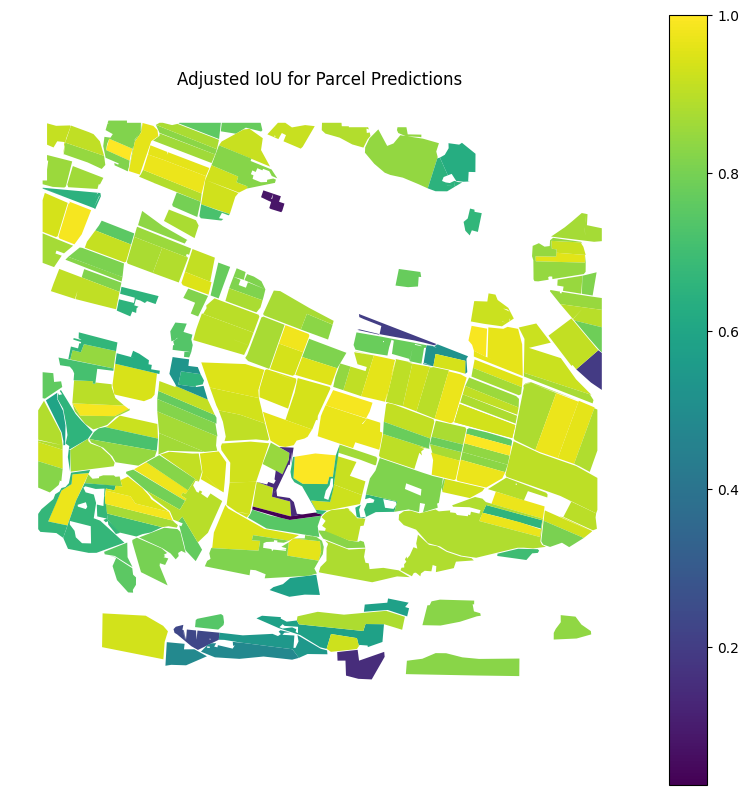

Total Original Area: 3604118.0102243824


In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

path = "/workspaces/Satelite/data/experiment/evaluation/ZH_ZH_parcel_2_analysis.gpkg"

# Load the GeoDataFrame
gdf = gpd.read_file(path)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='Adjusted IoU', cmap='viridis', legend=True)
plt.title("Adjusted IoU for Parcel Predictions")
plt.axis('off')
plt.show()

# Calculate the total area of the original parcels
total_original_area = gdf.geometry.area.sum()
print("Total Original Area:", total_original_area)



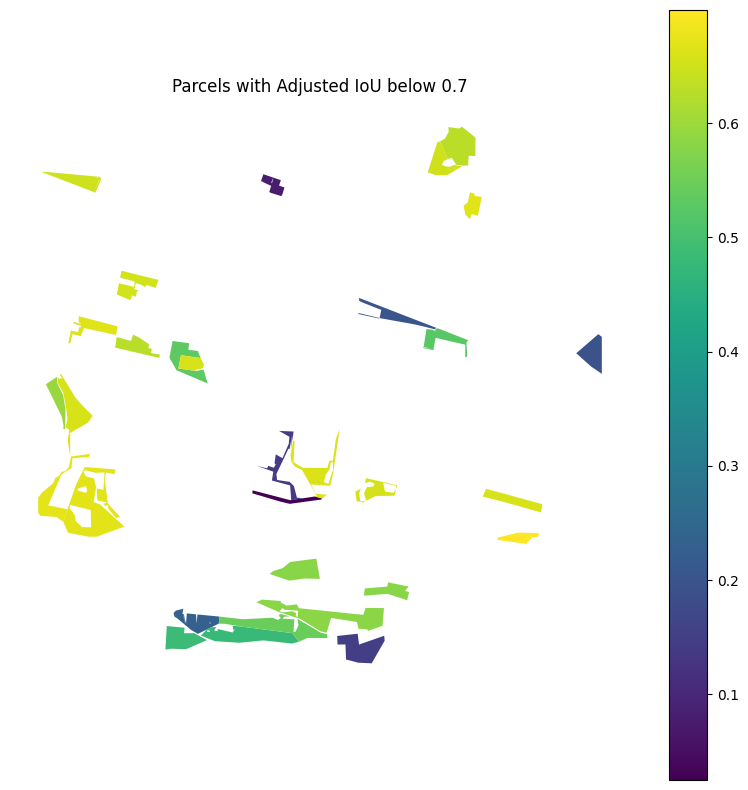

In [3]:
# Plot all parcels with an ioU score below 0.7 sort by Adjusted IoU in geodataframe
low_iou_gdf = gdf[gdf['Adjusted IoU'] <= 0.7].sort_values('Adjusted IoU')

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
low_iou_gdf.plot(ax=ax, column='Adjusted IoU', cmap='viridis', legend=True)
plt.title("Parcels with Adjusted IoU below 0.7")
plt.axis('off')
plt.show()


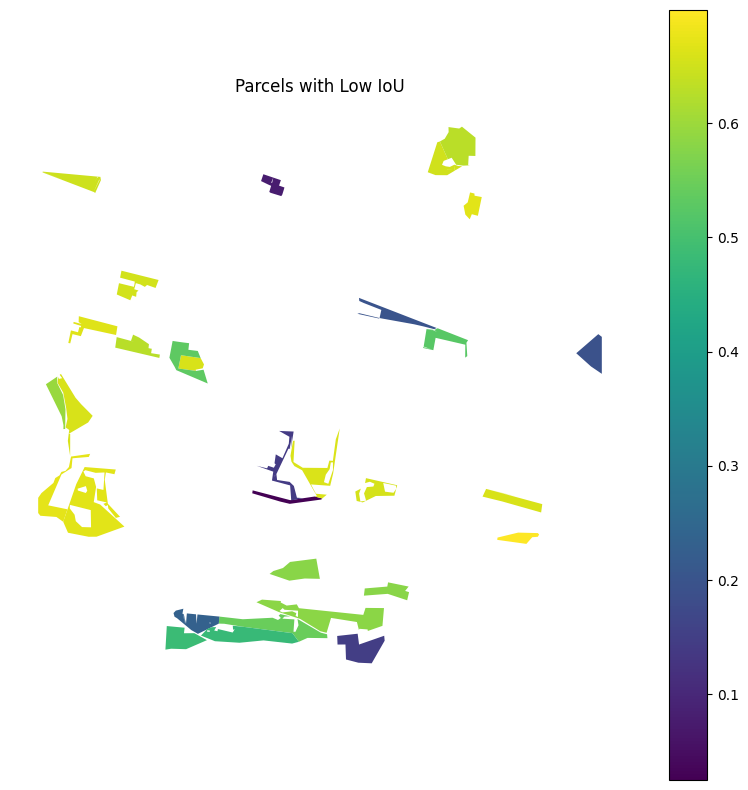

In [4]:
# Now plot using the Low IoU column
low_iou_gdf = gdf[gdf['Low IoU']]
fig, ax = plt.subplots(figsize=(10, 10))
low_iou_gdf.plot(ax=ax, column='Adjusted IoU', cmap='viridis', legend=True)
plt.title("Parcels with Low IoU")
plt.axis('off')
plt.show()


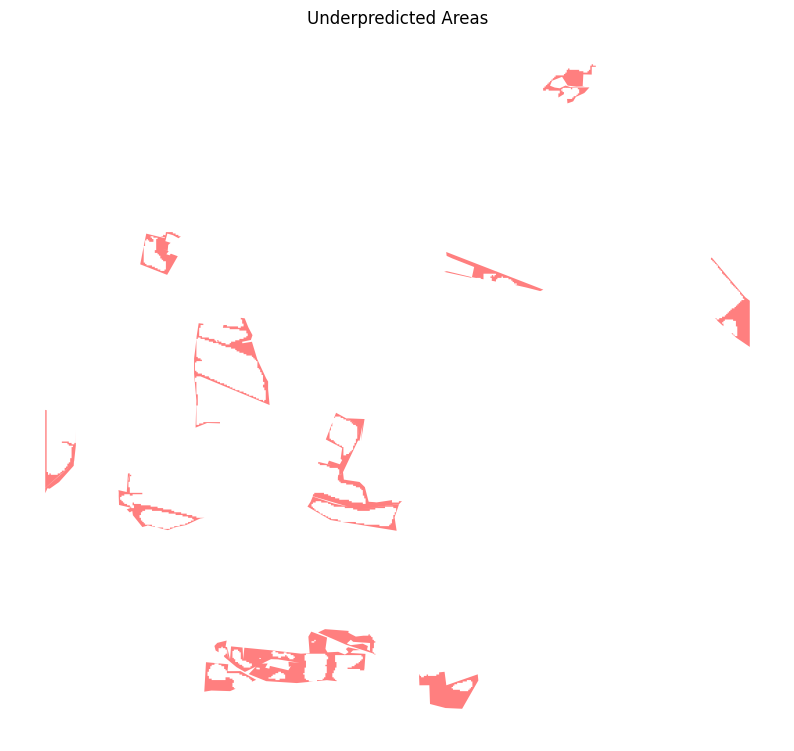

In [17]:
# load the underprediction file
path = "/workspaces/Satelite/data/experiment/evaluation/ZH_ZH_parcel_2_underprediction.gpkg"
underprediction_gdf = gpd.read_file(path)

# plot the underpredicted areas
fig, ax = plt.subplots(figsize=(10, 10))
underprediction_gdf.plot(ax=ax, color='red', alpha=0.5)
plt.title("Underpredicted Areas")
plt.axis('off')
plt.show()


In [15]:
# Calculate the total area of the original parcels
total_original_area = gdf.geometry.area.sum()
print("Total Original Area:", total_original_area)

# Calculate the total area of the low IoU parcels
low_iou_area = low_iou_gdf.geometry.area.sum()
print("Total Low IoU Area:", low_iou_area)


# Are there any parcels below 5000 m²?
small_parcels = gdf[gdf.geometry.area < 5000]
print("Number of small parcels:", len(small_parcels))

Total Original Area: 3604118.0102243824
Total Low IoU Area: 394587.2041885204
Number of small parcels: 0


Total Original Area: 157478.43374248885


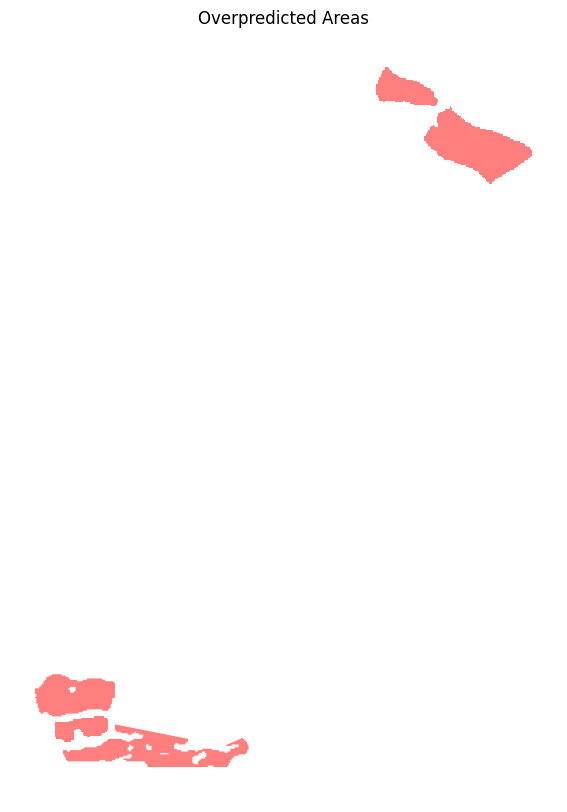

In [7]:
parz = "/workspaces/Satelite/data/experiment/evaluation/ZH_ZH_parcel_2_overprediction.gpkg"
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoDataFrame
gdf = gpd.read_file(parz)

#Calculate the total area of the original parcels
total_original_area = gdf.geometry.area.sum()
print("Total Original Area:", total_original_area)

# Visualize the overpredicted areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', alpha=0.5)
plt.title("Overpredicted Areas")
plt.axis('off')
plt.show()


Total Overpredicted Area: 170212.32445731884


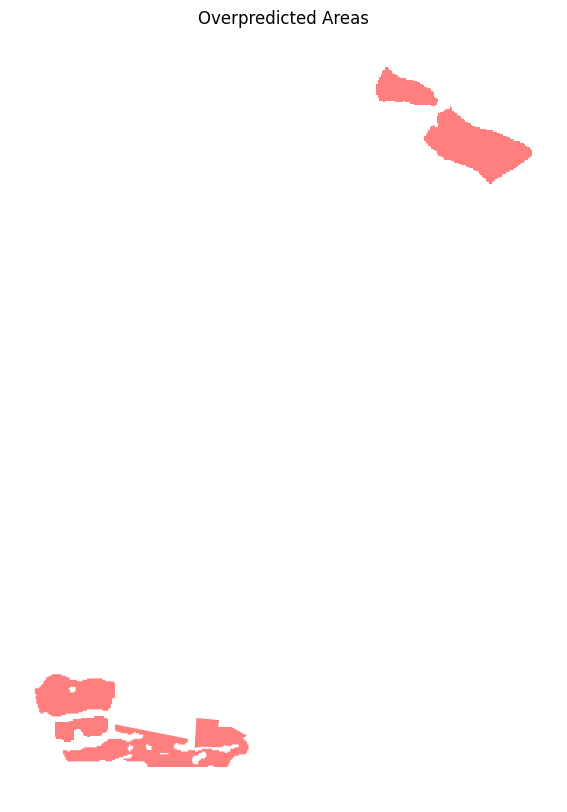

In [8]:
parz = "/workspaces/Satelite/data/experiment/evaluation/ZH_ZH_parcel_2_analysis.gpkg"
import geopandas as gpd

# Load the GeoDataFrame
gdf = gpd.read_file(parz)
#Look for Overprediction = True
overpredicted_gdf = gdf[gdf['Overpredicted']]
#Calculate the total area of the overpredicted parcels
total_overpredicted_area = overpredicted_gdf.geometry.area.sum()
print("Total Overpredicted Area:", total_overpredicted_area)

# Visualize the overpredicted areas
fig, ax = plt.subplots(figsize=(10, 10))
overpredicted_gdf.plot(ax=ax, color='red', alpha=0.5)
plt.title("Overpredicted Areas")
plt.axis('off')
plt.show()
